# Chapter 16:
    Reduce Overfitting with Dropout Regularization

In [1]:
# Import modules
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.optimizers import SGD
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
# fix random seed for reproducibility
seed = 7 
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
!ls

 AMMI_Models.py
 baseline_model_plot.png
'Deep Learning using Keras with Tensorflow and Theano Backend 4. Dropout.ipynb'
'Deep Learning with Keras using Tensorflow and Theano backend 2. Models..ipynb'
'Deep learning with Keras, using Tensorflow and Theano backend 3. Model checkpointing.ipynb'
'Deep Learning with Keras using Tensorflow and Theano backend, Python 1. Keras Structure..ipynb'
 iris.data
'Linear Algebra and Basics Mathematics..ipynb'
 model_plot.png
 Models
 Models_Boston_Data
 pima-indians-diabetes.data
 __pycache__
 sonar.all-data
 Weights


In [3]:
# Load Sonar dataset
data = pd.read_csv('sonar.all-data', header = None)
dataset = data.values
# split data into X and Y
X = dataset[:, :60].astype(float)
Y = dataset[:,60]

In [4]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [5]:
# Create baseline model
def baseline():
    model = Sequential()
    model.add(Dense(60, input_dim=60, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(30, kernel_initializer='uniform', activation = 'relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation = 'sigmoid'))
    # Compile the model
    sgd = SGD(learning_rate=0.01, momentum=0.8, decay =0.0, nesterov = False)
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model

In [6]:
estimator = []
estimator.append(('standardize', StandardScaler()))
estimator.append(('mlp', KerasClassifier(build_fn=baseline, epochs=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimator)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv = kfold)
print('Baseline: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

Baseline: 85.56% (8.65%)


#### Using Dropout on the visible layer

In [7]:
# Define model
def baseline2_dp():
    model = Sequential()
    model.add(Dropout(0.2, input_shape=(60, )))
    model.add(Dense(60, kernel_initializer='uniform', activation='relu', W_constraint=maxnorm(3)))
    model.add(Dense(30, kernel_initializer='uniform', activation = 'relu', W_constraint = maxnorm(3)))
    model.add(Dense(1, kernel_initializer='uniform', activation = 'sigmoid'))
    # Compile the model
    sgd = SGD(learning_rate=0.1, momentum=0.9, decay =0.0, nesterov = False)
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model

In [8]:
estimator = []
estimator.append(('standardize', StandardScaler()))
estimator.append(('mlp', KerasClassifier(build_fn=baseline_dp, epochs=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimator)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv = kfold)
print('Baseline: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

Baseline: 85.09% (5.87%)


In [9]:
import keras
keras.__version__

'2.3.1'

#### Dropout in the hidden layers

In [13]:
# Define model
def baseline3_dp():
    model = Sequential()
    model.add(Dense(60, input_dim = 60, kernel_initializer='uniform', activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(30, kernel_initializer='uniform', activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform', activation = 'sigmoid'))
    # Compile the model
    sgd = SGD(learning_rate=0.1, momentum=0.9, decay =0.0, nesterov = False)
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    return model

In [14]:
estimator = []
estimator.append(('standardize', StandardScaler()))
estimator.append(('mlp', KerasClassifier(build_fn=baseline3_dp, epochs=300, batch_size=16, verbose=0)))
pipeline = Pipeline(estimator)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, X, encoded_Y, cv = kfold)
print('Baseline: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

Baseline: 84.59% (6.01%)


Notes on using dropouts:
    1. Generally use a small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.
    2. Use a larger network. You are likely to get better performance when dropout is used on a larger network, giving the model more of an opportunity to learn independent representations.
    3. Use dropout on input (visible) as well as hidden layers. Application of dropout at each layer of the network has shown good results.
    4. Use a large learning rate with decay and a large momentum. Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99.
    5. Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights such as max-norm regularization with a size of 4 or 5 has been shown to improve results.

# Chapter 17:
    Lift performance with learning rate schedules

In [31]:
# Downlod ionosphere data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data

--2020-03-01 16:08:02--  http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76467 (75K) [application/x-httpd-php]
Saving to: ‘ionosphere.data’

ionosphere.data     100%[===================>]  74.67K  32.9KB/s    in 2.3s    

2020-03-01 16:08:06 (32.9 KB/s) - ‘ionosphere.data’ saved [76467/76467]



#### Understanding Learning rate schedulers

In [28]:
# Set decay constant, lr and starting epoch 
decay = 0.001
lr = 0.01
epoch = 0
# collect lr and epoch values
lr_list = []
epoch_list = []
# setup while loop for learning rate update
while epoch < 50:
    lr = lr * (1/(1+decay*epoch))
    epoch_list.append(epoch)
    lr_list.append(lr)
    epoch += 1    
    # print(lr)
# Verify the length of the lists.
len(epoch_list), len(lr_list)

(50, 50)

In [24]:
# Import module to plot
import matplotlib.pyplot as plt

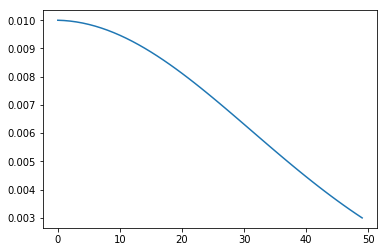

In [29]:
# plot epochs and learning rate
plt.plot(epoch_list, lr_list)
plt.show()

In [ ]:
Set a reducing decay using 
decay = lr/Number of epochs


# Set decay constant, lr and starting epoch 
decay = 0.001
lr = 0.01
epoch = 0
# collect lr and epoch values
lr_list = []
epoch_list = []
# setup while loop for learning rate update
while epoch < 50:
    lr = lr * (1/(1+decay*epoch))
    epoch_list.append(epoch)
    lr_list.append(lr)
    epoch += 1    
    # print(lr)
# Verify the length of the lists.
len(epoch_list), len(lr_list)

In [2]:
# Import modules useful to working
# Fix random seed
# Load dataset
dataset = pd.read_csv('ionosphere.data')
dataset = dataset.values
# split into X and Y
X = dataset[:,0:34].astype(float)
Y = dataset[:,34]

In [3]:
# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [34]:
# Create model
model = Sequential()
model.add(Dense(34, input_dim=34, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# compile model
epochs = 50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(loss = 'binary_crossentropy', optimizer= sgd, metrics = ['accuracy'])
# Fit the model
model.fit(X, encoded_Y, validation_split=0.33, epochs = epochs, batch_size=28, verbose=2)

Train on 234 samples, validate on 116 samples
Epoch 1/50
 - 0s - loss: 0.6906 - accuracy: 0.6026 - val_loss: 0.6814 - val_accuracy: 0.6983
Epoch 2/50
 - 0s - loss: 0.6742 - accuracy: 0.6795 - val_loss: 0.6072 - val_accuracy: 0.8621
Epoch 3/50
 - 0s - loss: 0.6245 - accuracy: 0.7735 - val_loss: 0.4987 - val_accuracy: 0.8879
Epoch 4/50
 - 0s - loss: 0.5472 - accuracy: 0.8162 - val_loss: 0.4475 - val_accuracy: 0.9569
Epoch 5/50
 - 0s - loss: 0.4528 - accuracy: 0.8291 - val_loss: 0.3826 - val_accuracy: 0.9224
Epoch 6/50
 - 0s - loss: 0.3764 - accuracy: 0.8632 - val_loss: 0.3780 - val_accuracy: 0.8879
Epoch 7/50
 - 0s - loss: 0.3312 - accuracy: 0.8718 - val_loss: 0.2983 - val_accuracy: 0.9224
Epoch 8/50
 - 0s - loss: 0.2838 - accuracy: 0.8932 - val_loss: 0.2615 - val_accuracy: 0.9224
Epoch 9/50
 - 0s - loss: 0.2490 - accuracy: 0.9017 - val_loss: 0.2027 - val_accuracy: 0.9397
Epoch 10/50
 - 0s - loss: 0.2259 - accuracy: 0.9188 - val_loss: 0.1915 - val_accuracy: 0.9569
Epoch 11/50
 - 0s - los

In [ ]:
# DO NOT RUN
# Set decay constant, lr and starting epoch 
decay = 0.001
lr = 0.01
epoch = 0
# collect lr and epoch values
lr_list = []
epoch_list = []
# setup while loop for learning rate update

while epoch < 50:
    if epoch%10 == 0:
        lr = lr * (1/(1+decay*epoch))
        epoch_list.append(epoch)
        lr_list.append(lr)
    else:
        epoch += 1    
    # print(lr)
# Verify the length of the lists.
len(epoch_list), len(lr_list)

In [ ]:
LearningRate = InitialLearningRate * DropRate ^ (floor((1+epoch)/epochDrop))

In [6]:
# Learning rate schedule using the learning rate scheduler
import math
from keras.callbacks import LearningRateScheduler
# define learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 100.0
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch)/epochs_drop))
    return lrate

# Set random seed
seed = 7
np.random.seed(seed)
# Load dataset
# Split dataset
# Encode Y variable
# Create model
model = Sequential()
model.add(Dense(34, input_dim=34, kernel_initializer='uniform', activation = 'relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'sigmoid'))

# compile the model
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov = False)
model.compile(loss= 'binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

In [8]:
# Fit the model
model.fit(X, encoded_Y, validation_split=0.33, epochs=50, batch_size=28, callbacks=callbacks_list, verbose=2)

Train on 234 samples, validate on 116 samples
Epoch 1/50
 - 0s - loss: 0.6883 - accuracy: 0.6282 - val_loss: 0.6523 - val_accuracy: 0.7328
Epoch 2/50
 - 0s - loss: 0.6500 - accuracy: 0.6111 - val_loss: 0.4649 - val_accuracy: 0.9310
Epoch 3/50
 - 0s - loss: 0.5678 - accuracy: 0.7650 - val_loss: 0.5561 - val_accuracy: 0.7155
Epoch 4/50
 - 0s - loss: 0.4541 - accuracy: 0.7821 - val_loss: 0.1963 - val_accuracy: 0.9569
Epoch 5/50
 - 0s - loss: 0.3832 - accuracy: 0.8504 - val_loss: 0.3187 - val_accuracy: 0.9310
Epoch 6/50
 - 0s - loss: 0.2853 - accuracy: 0.8932 - val_loss: 0.2564 - val_accuracy: 0.9224
Epoch 7/50
 - 0s - loss: 0.2462 - accuracy: 0.8889 - val_loss: 0.2705 - val_accuracy: 0.9052
Epoch 8/50
 - 0s - loss: 0.2234 - accuracy: 0.9274 - val_loss: 0.1568 - val_accuracy: 0.9569
Epoch 9/50
 - 0s - loss: 0.1753 - accuracy: 0.9316 - val_loss: 0.1612 - val_accuracy: 0.9397
Epoch 10/50
 - 0s - loss: 0.1642 - accuracy: 0.9402 - val_loss: 0.2050 - val_accuracy: 0.9569
Epoch 11/50
 - 0s - los

In [ ]:
# Exponential Learning rate decay
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * exp(-k*t)
    return lrate

# Implement with LearningRateScheduler

Learning Rate Schedule Tips:
    
    1. Increase the initial learning rate. Because the learning rate will decrease, start with a larger value to decrease from. A larger learning rate will result in a lot larger changes to the weights, at least in the beginning, allowing you to benefit from fine tuning later.
    2. Use a large momentum. Using a larger momentum value will help the optimization algorithm to continue to make updates in the right direction when your learning rate shrinks to small values.
    3. Experiment with different schedules. It will not be clear which learning rate schedule to use so try a few with di↵erent configuration options and see what works best on your problem. Also try schedules that change exponentially and even schedules that respond to the accuracy of your model on the training or test datasets.